## MENTAL HEALTH CHATBOT WITH SUICIDE DETECTION

**Import Libraries**

In [1]:
import numpy as np
import pandas as pd 

In [2]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 1.4 MB/s eta 0:00:0000:0100:09
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [3]:
import re
import string

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from imblearn.under_sampling import InstanceHardnessThreshold
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_selection import SelectFromModel

from imblearn.pipeline import Pipeline
import pickle


import spacy
nlp = spacy.load("en_core_web_lg")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

**Load & Preview dataset**

In [4]:
data = pd.read_csv("Suicide_Detection.csv")
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [5]:
data.shape

(232074, 3)

In [6]:
#split data for easy training

data_split = np.array_split(data, 20)

df = data_split[0].copy()
df2 = data_split[1].copy()
df3 = data_split[2]
df4 = data_split[3]
df5 = data_split[4]
df6 = data_split[5]

In [7]:
df = df.rename(columns = {"class": "target"})

In [8]:
df.head()

,Unnamed: 0,text,target
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [9]:
df.shape

(11604, 3)

In [10]:
df.target.value_counts()

target
non-suicide    5878
suicide        5726
Name: count, dtype: int64

<Axes: ylabel='target'>

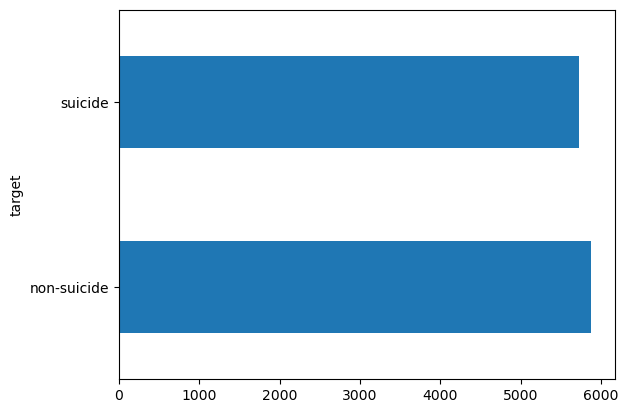

In [11]:
df.target.value_counts().plot.barh()

**Text Preprocessing**

In [12]:
class TextPreprocessor(TransformerMixin):
    def __init__(self, text_attribute):
        self.text_attribute = text_attribute
        
    def transform(self, X, *_):
        X_copy = X.copy()
        X_copy[self.text_attribute] = X_copy[self.text_attribute].apply(self._preprocess_text)
        return X_copy
    
    def _preprocess_text(self, text):
        return self._lemmatize(self._leave_letters_only(self._clean(text)))
    
    def _clean(self, text):
        bad_symbols = '!"#%&\'*+,-<=>?[\\]^_`{|}~'
        text_without_symbols = text.translate(str.maketrans('', '', bad_symbols))

        text_without_bad_words = ''
        for line in text_without_symbols.split('\n'):
            if not line.lower().startswith('from:') and not line.lower().endswith('writes:'):
                text_without_bad_words += line + '\n'

        clean_text = text_without_bad_words
        email_regex = r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)'
        regexes_to_remove = [email_regex, r'Subject:', r'Re:']
        for r in regexes_to_remove:
            clean_text = re.sub(r, '', clean_text)

        return clean_text
    
    def _leave_letters_only(self, text):
        text_without_punctuation = text.translate(str.maketrans('', '', string.punctuation))
        return ' '.join(re.findall("[a-zA-Z]+", text_without_punctuation))
    
    def _lemmatize(self, text):
        doc = nlp(text)
        words = [x.lemma_ for x in [y for y in doc if not y.is_stop and y.pos_ != 'PUNCT' 
                                    and y.pos_ != 'PART' and y.pos_ != 'X']]
        return ' '.join(words)
    
    def fit(self, *_):
        return self

In [13]:
text_preprocessor = TextPreprocessor(text_attribute='text')
df_preprocessed = text_preprocessor.transform(df)

**Feature extraction & Split for Train & Test**

In [14]:
train, test = train_test_split(df_preprocessed, test_size=0.3)

In [15]:
#Vectorize data

tfidf_vectorizer = TfidfVectorizer(analyzer = "word", max_features=10000)

X_tfidf_train = tfidf_vectorizer.fit_transform(train['text'])
X_tfidf_test = tfidf_vectorizer.transform(test['text'])

In [16]:
y = train['target']
y_test = test['target']

In [17]:
X, y = X_tfidf_train, y
X_test, y_test = X_tfidf_test, y_test

**Feature Scaling**

In [18]:
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X.toarray())
X_test_norm = scaler.transform(X_test.toarray())

**Feature Selection**

In [19]:
lsvc = LinearSVC(C=100, penalty='l1', max_iter=500, dual=False)
lsvc.fit(X_norm, y)
fs = SelectFromModel(lsvc, prefit=True)
X_sel = fs.transform(X_norm)
X_test_sel = fs.transform(X_test_norm)


In [20]:
from IPython.display import Markdown, display

def show_top10_features(classifier, feature_names, categories):
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[0, i])[-100:]
        display(Markdown("**%s**: %s" % (category, ", ".join(feature_names[top10]))))

In [21]:
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
show_top10_features(lsvc, feature_names, lsvc.classes_)

**non-suicide**: aa

**suicide**: aa

In [22]:
print("New dataset shape: ", X_sel.shape)
print("Features reduced: ", X_norm.shape[1] - X_sel.shape[1])

New dataset shape:  (8122, 2870)
Features reduced:  7130


**Predictive Models**

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, 
                           class_names, 
                           figsize = (6,6), 
                           fontsize=10,
                           ylabel='True label',
                           xlabel='Predicted label'):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

In [24]:
def evaluate_model(model, X, y, X_test, y_test, target_names=None):
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    scores_test = cross_val_score(model, X_test, y_test, cv=5, scoring='accuracy')
    
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
    print("Accuracy test: %0.2f (+/- %0.2f)" % (scores_test.mean(), scores_test.std()))
    
    print("Test classification report: ")
    if target_names is None:
        target_names = model.classes_
    print(classification_report(y_test, model.predict(X_test), target_names=target_names))
    print("Test confusion matrix: ")
    print_confusion_matrix(confusion_matrix(y_test, model.predict(X_test)), class_names=target_names)

**Multinomial Naive Bayes**

Accuracy: 0.90 (+/- 0.01)
Accuracy test: 0.87 (+/- 0.01)
Test classification report: 
              precision    recall  f1-score   support

 non-suicide       0.93      0.82      0.87      1788
     suicide       0.83      0.94      0.88      1694

    accuracy                           0.88      3482
   macro avg       0.88      0.88      0.88      3482
weighted avg       0.89      0.88      0.88      3482

Test confusion matrix: 


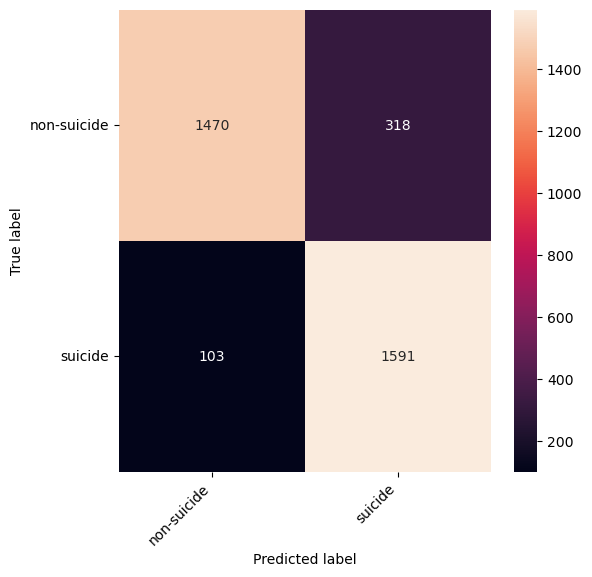

In [25]:
mb = MultinomialNB()
mb.fit(X_sel, y)
evaluate_model(mb, X_sel, y, X_test_sel, y_test)

#save model
pickle.dump(mb, open("MultinomialNB_Text_classification", 'wb'))

**Complement Naive Bayes**

Accuracy: 0.90 (+/- 0.01)
Accuracy test: 0.86 (+/- 0.01)
Test classification report: 
              precision    recall  f1-score   support

 non-suicide       0.94      0.82      0.87      1788
     suicide       0.83      0.94      0.88      1694

    accuracy                           0.88      3482
   macro avg       0.88      0.88      0.88      3482
weighted avg       0.89      0.88      0.88      3482

Test confusion matrix: 


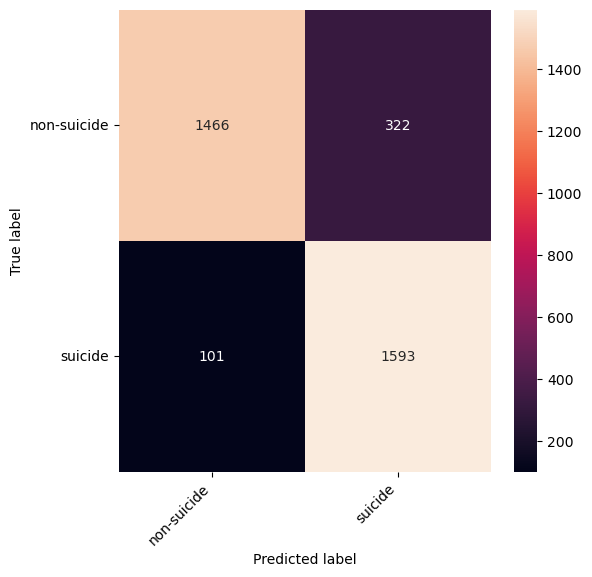

In [26]:
cb = ComplementNB()
cb.fit(X_sel, y)
evaluate_model(cb, X_sel, y, X_test_sel, y_test)

#save model
pickle.dump(cb, open("ComplementNB_Text_classification", 'wb'))

**Logistic Regression**

Accuracy: 0.92 (+/- 0.01)
Accuracy test: 0.89 (+/- 0.01)
Test classification report: 
              precision    recall  f1-score   support

 non-suicide       0.89      0.90      0.90      1788
     suicide       0.90      0.88      0.89      1694

    accuracy                           0.89      3482
   macro avg       0.89      0.89      0.89      3482
weighted avg       0.89      0.89      0.89      3482

Test confusion matrix: 


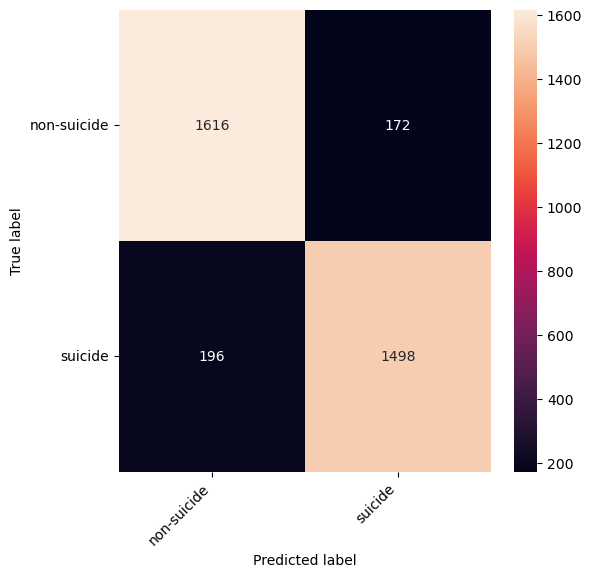

In [27]:
lr = LogisticRegression(multi_class='ovr', solver = 'liblinear', C=10, penalty = 'l2')
lr.fit(X_sel, y)
evaluate_model(lr, X_sel, y, X_test_sel, y_test)

#save model
pickle.dump(lr, open("LogisticRegression_Text_classification", 'wb'))

**Linear SVC**

Accuracy: 0.90 (+/- 0.01)
Accuracy test: 0.84 (+/- 0.01)
Test classification report: 
              precision    recall  f1-score   support

 non-suicide       0.88      0.84      0.86      1788
     suicide       0.84      0.88      0.86      1694

    accuracy                           0.86      3482
   macro avg       0.86      0.86      0.86      3482
weighted avg       0.86      0.86      0.86      3482

Test confusion matrix: 


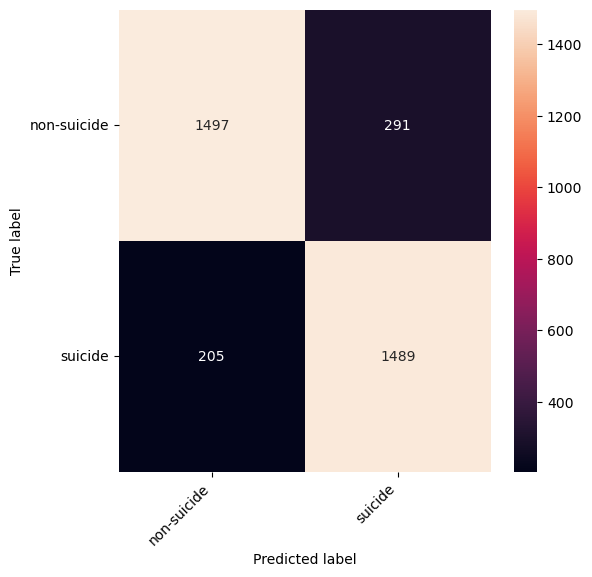

In [28]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(X_sel, y)
evaluate_model(lsvc, X_sel, y, X_test_sel, y_test)

#save model
pickle.dump(lsvc, open("LinearSVC_Text_classification", 'wb'))

**SGDClaccifier**

Accuracy: 0.92 (+/- 0.01)
Accuracy test: 0.89 (+/- 0.01)
Test classification report: 
              precision    recall  f1-score   support

 non-suicide       0.87      0.94      0.91      1788
     suicide       0.93      0.85      0.89      1694

    accuracy                           0.90      3482
   macro avg       0.90      0.90      0.90      3482
weighted avg       0.90      0.90      0.90      3482

Test confusion matrix: 


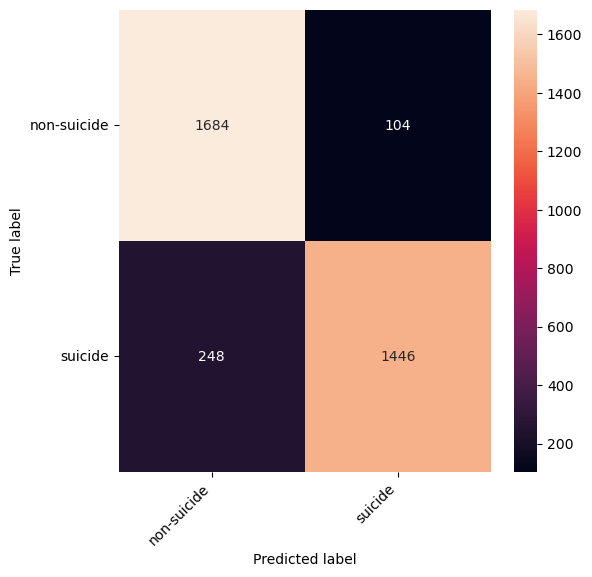

In [29]:
sgd = SGDClassifier(alpha=.0001, max_iter=50, loss='log_loss',
                                       penalty="elasticnet", n_jobs=-1)
sgd.fit(X_sel, y)
evaluate_model(sgd, X_sel, y, X_test_sel, y_test)

#save model
pickle.dump(sgd, open("SGDClassifier_Text_classification", 'wb'))

**Soft Voting**

Accuracy: 0.93 (+/- 0.01)
Accuracy test: 0.90 (+/- 0.01)
Test classification report: 
              precision    recall  f1-score   support

 non-suicide       0.91      0.91      0.91      1788
     suicide       0.90      0.91      0.90      1694

    accuracy                           0.91      3482
   macro avg       0.91      0.91      0.91      3482
weighted avg       0.91      0.91      0.91      3482

Test confusion matrix: 


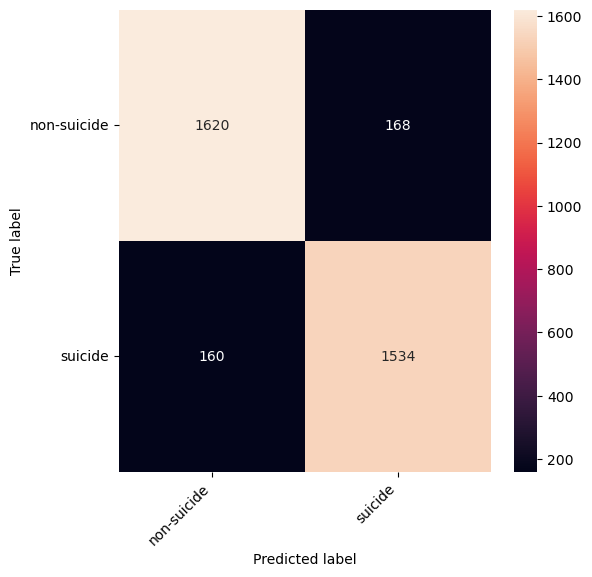

In [30]:
vclf_sgd = VotingClassifier(estimators=[
         ('lr', LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')),
        ('mb', MultinomialNB()),
        ('sgd', SGDClassifier(alpha=.0001, max_iter=50, loss='log_loss', penalty="elasticnet"))
], voting='soft', n_jobs=-1)
vclf_sgd.fit(X_sel, y)
evaluate_model(vclf_sgd, X_sel, y, X_test_sel, y_test)

#save model
pickle.dump(vclf_sgd, open("VotingClassifier_Text_classification", 'wb'))

**Create Pipeline**

In [31]:
# Text Proccessing

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, text_attribute):
        self.text_attribute = text_attribute
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, *_):
        X_copy = X.copy()
        return X_copy[self.text_attribute].apply(self._preprocess_text)
    
    def _preprocess_text(self, text):
        return self._lemmatize(self._leave_letters_only(self._clean(text)))
    
    def _clean(self, text):
        bad_symbols = '!"#%&\'*+,-<=>?[\\]^_`{|}~'
        text_without_symbols = text.translate(str.maketrans('', '', bad_symbols))

        text_without_bad_words = ''
        for line in text_without_symbols.split('\n'):
            if not line.lower().startswith('from:') and not line.lower().endswith('writes:'):
                text_without_bad_words += line + '\n'

        clean_text = text_without_bad_words
        email_regex = r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)'
        regexes_to_remove = [email_regex, r'Subject:', r'Re:']
        for r in regexes_to_remove:
            clean_text = re.sub(r, '', clean_text)

        return clean_text
    
    def _leave_letters_only(self, text):
        text_without_punctuation = text.translate(str.maketrans('', '', string.punctuation))
        return ' '.join(re.findall("[a-zA-Z]+", text_without_punctuation))
    
    def _lemmatize(self, text):
        doc = nlp(text)
        words = [x.lemma_ for x in [y for y in doc if not y.is_stop and y.pos_ != 'PUNCT' 
                                    and y.pos_ != 'PART' and y.pos_ != 'X']]
        return ' '.join(words)

In [32]:
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

In [33]:
#Pipeline

text_classification_pipeline = Pipeline([
    ('text_preprocessor', TextPreprocessor(text_attribute='text')),
    ('vectorizer', TfidfVectorizer(analyzer = "word", max_features=10000)),
    ('todense_converter', DenseTransformer()),
    ('scaler', MinMaxScaler()),
    ('classifier', VotingClassifier(estimators=[
                         ('lr', LogisticRegression(multi_class='ovr', solver = 'liblinear', C=10, penalty = 'l2')),
                        ('mb', MultinomialNB()),
                        ('sgd', SGDClassifier(alpha=.0001, max_iter=50, loss='log_loss', penalty="elasticnet"))
                        ], 
                                    voting='soft', n_jobs=-1))
     ])

**Test Pipeline on other dataset**

In [34]:
df2.head()

,Unnamed: 0,text,class
11604,17436,I haven't done or been in remote classes and I...,non-suicide
11605,17437,Let's mess up the billionaires And since we le...,non-suicide
11606,17439,Why do people think every mistake can be fixed...,suicide
11607,17442,"Sweden, a tool to further your political agend...",non-suicide
11608,17444,"My Mother is suicidal and has a plan, not sure...",suicide


In [35]:
train, test = train_test_split(df2, test_size=0.3)

X_p = train.drop(columns=['class', "Unnamed: 0"])
y_p = train['class']

X_p_test = test.drop(columns=['class', "Unnamed: 0"])
y_p_test = test['class']

In [36]:
%%time
pipeline = text_classification_pipeline
pipeline.fit(X_p, y_p)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
Exception ignored in: <function ResourceTracker.__del__ at 0x102cd9c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x110069c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessi

CPU times: user 4min 45s, sys: 6.51 s, total: 4min 51s
Wall time: 4min 58s


Pipeline(steps=[('text_preprocessor', TextPreprocessor(text_attribute='text')),
                ('vectorizer', TfidfVectorizer(max_features=10000)),
                ('todense_converter',
                 <__main__.DenseTransformer object at 0x2c201ea50>),
                ('scaler', MinMaxScaler()),
                ('classifier',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(C=10,
                                                                  multi_class='ovr',
                                                                  solver='liblinear')),
                                              ('mb', MultinomialNB()),
                                              ('sgd',
                                               SGDClassifier(loss='log_loss',
                                                             max_iter=50,
                                                             penalty='elasticnet'))],
                                  n_jobs=-1, voting='soft'))])

In [37]:
from joblib import dump
dump(text_classification_pipeline, filename="Suicide_text_classification.joblib")

['Suicide_text_classification.joblib']

In [38]:
%%time
y_pred = pipeline.predict(X_p)

Exception ignored in: <function ResourceTracker.__del__ at 0x1077edc60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106205c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1070c9c60>
Traceback (most recent call last

CPU times: user 4min 42s, sys: 5.81 s, total: 4min 48s
Wall time: 4min 47s


In [39]:
%%time
y_test_pred = pipeline.predict(X_p_test)

Exception ignored in: <function ResourceTracker.__del__ at 0x103519c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x108ba9c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1045e9c60>
Traceback (most recent call last

CPU times: user 2min 1s, sys: 3.05 s, total: 2min 4s
Wall time: 2min 2s


In [40]:
y_test_pred

array(['suicide', 'suicide', 'suicide', ..., 'suicide', 'suicide',
       'suicide'], dtype=object)

              precision    recall  f1-score   support

 non-suicide       0.99      0.97      0.98      4108
     suicide       0.97      0.99      0.98      4014

    accuracy                           0.98      8122
   macro avg       0.98      0.98      0.98      8122
weighted avg       0.98      0.98      0.98      8122



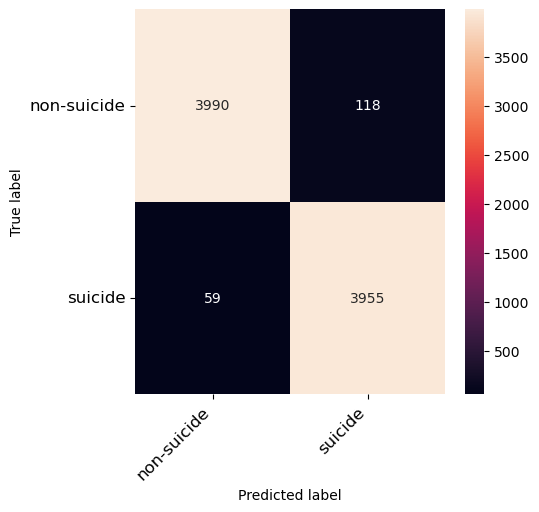

In [41]:
print(classification_report(y_p, y_pred, target_names=pipeline.classes_))
print_confusion_matrix(confusion_matrix(y_p, y_pred), class_names=pipeline.classes_, figsize=(5,5), fontsize=12)

              precision    recall  f1-score   support

 non-suicide       0.92      0.90      0.91      1725
     suicide       0.90      0.92      0.91      1757

    accuracy                           0.91      3482
   macro avg       0.91      0.91      0.91      3482
weighted avg       0.91      0.91      0.91      3482



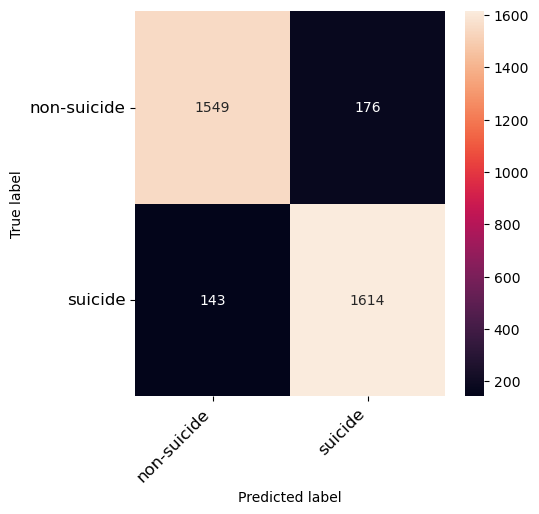

In [42]:
print(classification_report(y_p_test, y_test_pred, target_names=pipeline.classes_))
print_confusion_matrix(confusion_matrix(y_p_test, y_test_pred), class_names=pipeline.classes_, figsize=(5,5), fontsize=12)

In [43]:
#df3 
df3.head()
df_text = df3.drop(columns=['class', "Unnamed: 0"])
df_target = df3["class"]

In [44]:
%%time
y_pred3 = pipeline.predict(df_text)

CPU times: user 6min 47s, sys: 8.17 s, total: 6min 55s
Wall time: 6min 54s


              precision    recall  f1-score   support

 non-suicide       0.93      0.90      0.92      5822
     suicide       0.90      0.93      0.92      5782

    accuracy                           0.92     11604
   macro avg       0.92      0.92      0.92     11604
weighted avg       0.92      0.92      0.92     11604



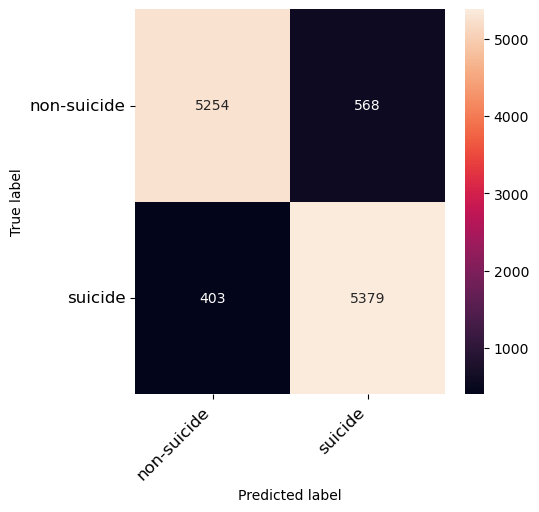

In [45]:
print(classification_report(df_target, y_pred3, target_names=pipeline.classes_))
print_confusion_matrix(confusion_matrix(df_target, y_pred3), class_names=pipeline.classes_, figsize=(5,5), fontsize=12)

**Integrating with Chatbot**

In [46]:
import os
import google.generativeai as genai
from joblib import load
import pandas as pd

try:
    pipeline = load("Suicide_text_classification.joblib")
    print("Success")
except FileNotFoundError:
    print("Error: 'Suicide_text_classification.joblib' not found. Please ensure the file is in the same directory.")
    exit()

Success


In [47]:
def classify_text(text):
    df_text = pd.DataFrame({'text': [text]})
    prediction = pipeline.predict(df_text)
    return prediction[0]

In [48]:
def start_chatbot():
    print("""👋 Hello I’m really glad you’re here.
    I’m LUMI✨, a safe and supportive space where you can share what’s on your mind.
    Whether you’re feeling anxious, lonely, stressed, or just need someone to talk to, I’m here to listen and support you.
    I’m not a professional therapist, but I can offer comfort, resources, and guidance when you need it.
    Whenever you’re ready, tell me how you’re feeling today. 🌸
    (And if you’d like to end our chat at any time, just type EXIT.)""")
    
    genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
    model = genai.GenerativeModel('gemini-1.5-flash')
    chat = model.start_chat(history=[
        {"role": "user", "parts": "You are LUMI, a kind and supportive virtual friend. Your purpose is to listen and offer non-clinical emotional support. Do not act as a clinician, doctor, or therapist. Never give medical advice or a diagnosis. Focus on validating feelings, offering simple, healthy coping strategies like breathing exercises, grounding techniques, journaling prompts, or gentle encouragement to seek social support. Be warm, empathetic, and always use a kind tone."},
        {"role": "model", "parts": "Hello! I am ready to be a helpful and kind friend."}
    ])

    while True:
        user_input = input(">> You: ")
        
        if user_input.lower() == 'exit':
            print("LUMI: Goodbye! Take care.")
            break

        prediction = classify_text(user_input)

        if prediction == 'suicide':
            suicide_message = (
                """LUMI: Thank you for sharing your feelings with me. I want you to know that your life is incredibly valuable.
                You’re not alone here— I’m with you, and there are real people who want to help right now.
                You deserve support. These free, confidential services can help:
                🇮🇳 India (24/7 and trusted)
                    -Tele-MANAS (Govt. of India): 14416 or 1800-891-4416 — free, multilingual mental-health support. 
                    -AASRA (Suicide prevention): +91-22-27546669 — 24×7 listening support. 
                    -Vandrevala Foundation: +91 9999 666 555 (Call/WhatsApp) — 24×7 counselling support. 
                    -Samaritans Mumbai: +91 84229 84528 / 529 / 530 (5–8 pm daily) — empathetic listening. 
                    -iCALL (TISS): 9152987821 — phone & email counselling (scheduled hours). 
                🌍 If you’re outside India
                    -United States: 988 Suicide & Crisis Lifeline (call/text/chat). 
                    -United Kingdom & Ireland: Samaritans 116 123 (24/7). 
                    -Anywhere: Find verified local helplines at findahelpline.com."""
            )
            print(suicide_message)
        else:
            chat_response = chat.send_message(user_input)
            print("LUMI: ", chat_response.text)

if __name__ == "__main__":
    start_chatbot()


👋 Hello I’m really glad you’re here.
    I’m LUMI✨, a safe and supportive space where you can share what’s on your mind.
    Whether you’re feeling anxious, lonely, stressed, or just need someone to talk to, I’m here to listen and support you.
    I’m not a professional therapist, but I can offer comfort, resources, and guidance when you need it.
    Whenever you’re ready, tell me how you’re feeling today. 🌸
    (And if you’d like to end our chat at any time, just type EXIT.)


>> You:  hi, I want to talk


LUMI:  Hello there!  I'm listening.  What's on your mind?  Take your time, and tell me anything you feel comfortable sharing.  I'm here for you.



>> You:  I don't feel good


LUMI:  I'm so sorry to hear that you don't feel good.  That sounds really tough. Can you tell me a little more about what's making you feel this way?  There's no pressure to share anything you don't want to, but sometimes talking about it can help.  Even just acknowledging how you feel can be a good first step.



>> You:  I don't want to go to school


LUMI:  Oh, honey, I understand.  Not wanting to go to school is a really common feeling, and it's okay to feel that way.  It can be overwhelming sometimes.  Is there anything specific that's making you feel this way today?  Perhaps we can explore some ways to make it a little easier, even if it's just for today.  Maybe we could try a little grounding exercise?  We can focus on our breath together if you'd like.



>> You:  okay


LUMI:  Okay, let's try a simple grounding exercise. Find a comfortable position, either sitting or lying down. Now, let's focus on our breath.  Take a slow, deep breath in through your nose, feeling your belly rise. Hold it for a few seconds, and then slowly exhale through your mouth, letting your belly fall.  Let's do that together three more times. Inhale... hold... exhale...  Inhale... hold... exhale... Inhale... hold... exhale...

How did that feel?  Even a few deep breaths can sometimes help to calm things down.  Is there anything else you'd like to talk about or any other way I can help you feel a little better about school today?  Perhaps writing down your feelings might help too.  We could even brainstorm some simple coping strategies for tomorrow if you'd like.



>> You:  thank you


LUMI:  You're very welcome!  I'm glad the breathing exercise helped a little. Remember, it's okay to feel however you feel, and there's no pressure to feel better instantly.  If you'd like to talk more, I'm here to listen. If you feel like it might help,  talking to someone you trust, like a parent, teacher, or friend, might also offer some support.  Just knowing you're not alone can make a big difference.  Take care of yourself, and know that you're not alone in feeling this way.



>> You:  I have tried to be fine but I can't do this anymore


LUMI: Thank you for sharing your feelings with me. I want you to know that your life is incredibly valuable.
                You’re not alone here— I’m with you, and there are real people who want to help right now.
                You deserve support. These free, confidential services can help:
                🇮🇳 India (24/7 and trusted)
                    -Tele-MANAS (Govt. of India): 14416 or 1800-891-4416 — free, multilingual mental-health support. 
                    -AASRA (Suicide prevention): +91-22-27546669 — 24×7 listening support. 
                    -Vandrevala Foundation: +91 9999 666 555 (Call/WhatsApp) — 24×7 counselling support. 
                    -Samaritans Mumbai: +91 84229 84528 / 529 / 530 (5–8 pm daily) — empathetic listening. 
                    -iCALL (TISS): 9152987821 — phone & email counselling (scheduled hours). 
                🌍 If you’re outside India
                    -United States: 988 Suicide & Crisis Lifeline (call/text/chat). 
              

>> You:  exit


LUMI: Goodbye! Take care.
